<a href="https://colab.research.google.com/github/TapanPathak/Object-Detection-using-Convolutional-Neural-Netwroks/blob/main/Deep_Learning_Based_Object_Detection_Using_Convolutional_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AIM** : ***Deep Learning Based Object Detection / Image Classification Using Convolutional Neural Networks***

***Author: Tapan Pathak***

***Technologies/Librabries/Concepts Used:***

**Deep Learning Based Object Detection, Convolutional Neural Network, Fine Tuning, Transfer Learning.**

1.   **TensorFlow**
2.   **TensorFlow Lite**
3.   **Keras**
4.   **OpenCv**




* **Download the required Dog and Cat Dataset and Unzip the Dataset in Google Colab Files.**

In [ ]:
!wget 'http://temp.endeavourindustries.in/Dataset.zip'

--2021-02-24 14:26:48--  http://temp.endeavourindustries.in/Dataset.zip
Resolving temp.endeavourindustries.in (temp.endeavourindustries.in)... 104.21.31.147, 172.67.177.202, 2606:4700:3036::ac43:b1ca, ...
Connecting to temp.endeavourindustries.in (temp.endeavourindustries.in)|104.21.31.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74430917 (71M) [application/x-zip-compressed]
Saving to: ‘Dataset.zip’

Dataset.zip         100%[===================>]  70.98M   988KB/s    in 81s     

2021-02-24 14:28:10 (899 KB/s) - ‘Dataset.zip’ saved [74430917/74430917]



In [ ]:
!unzip Dataset.zip

Archive:  Dataset.zip
   creating: Cat/
   creating: Cat/Images/
   creating: Cat/Images/model_test/
  inflating: Cat/Images/model_test/img1.jpg  
  inflating: Cat/Images/model_test/img10.jpg  
  inflating: Cat/Images/model_test/img11.jpg  
  inflating: Cat/Images/model_test/img12.jpg  
  inflating: Cat/Images/model_test/img13.jpg  
  inflating: Cat/Images/model_test/img14.jpg  
  inflating: Cat/Images/model_test/img15.jpg  
  inflating: Cat/Images/model_test/img16.jpg  
  inflating: Cat/Images/model_test/img17.jpg  
  inflating: Cat/Images/model_test/img18.jpg  
  inflating: Cat/Images/model_test/img19.jpg  
  inflating: Cat/Images/model_test/img2.jpg  
  inflating: Cat/Images/model_test/img20.jpg  
  inflating: Cat/Images/model_test/img21.jpg  
  inflating: Cat/Images/model_test/img22.jpg  
  inflating: Cat/Images/model_test/img23.jpg  
  inflating: Cat/Images/model_test/img24.jpg  
  inflating: Cat/Images/model_test/img25.jpg  
  inflating: Cat/Images/model_test/img26.jpg  
  inflat

* **Import the necessary packages required.**




In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
import time 
import os
import glob
import cv2
import matplotlib.pyplot as plt
from tensorflow.lite.python.interpreter import Interpreter
from keras.layers import Dense, Input, Dropout, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers import Flatten
from keras.losses import binary_crossentropy
#Import the DenseNet Model Version 121
from keras.applications.densenet import DenseNet121


* **Provide proper paths to the unzipped dataset and paths for models to be saved in Google Colab Files**

In [ ]:
#Paths to Dataset Directory in your Google Drive
Directory_Path = '/content/Cat' 

path_to_tensorflow_model = Directory_Path+"/Models/Tensorflow-Models/client.h5"
path_to_tflite_model = Directory_Path+"/Models/Tensorflow-Lite-Models/client.tflite"

In [ ]:
#Paths for Training,Testing and Validation
train_path = Directory_Path+'/Images//model_train/train'
valid_path = Directory_Path+'/Images/model_train/valid'
test_path = Directory_Path+'/Images//model_train/test'

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 450 images belonging to 2 classes.
Found 90 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


* ***Start Fine Tuning and Transfer Learning on pre-trained DenseNet Model***

In [ ]:
#Fine Tuning and Transfer Learning Function for DenseNet Model
def get_model_classif_desnet():
    inputs = Input((224,224, 3))
    #Load the pretrained DenseNet model
    base_model = DenseNet121(include_top=False)#, weights=None
    x = base_model(inputs)
    #Rebuild Top
    out1 = GlobalMaxPooling2D()(x)
    out2 = GlobalAveragePooling2D()(x)
    out3 = Flatten()(x)
    out = Concatenate(axis=-1)([out1, out2, out3])
    out = Dropout(0.5)(out)
    out = Dense(2, activation="softmax")(out)
    model = Model(inputs, out)
    #Freeze the other layers of Model for Training
    for layer in model.layers[:-5]:
      layer.trainable = False
    
    model.compile(optimizer=Adam(0.0001), loss=binary_crossentropy, metrics=['acc'])
    model.summary()
    return model
model = get_model_classif_desnet()

29089792/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
densenet121 (Functional)        (None, None, None, 1 7037504     input_1[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d (GlobalMax (None, 1024)         0           densenet121[0][0]                
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 1024)         0           densenet121[0][0]                
_____________________________

* ***Start Fine Tuning Training on DenseNet Model with our training data***

In [ ]:
#Train the DenseNet Model with our train and valid data
epochs = 10
start = time.time()
history = model.fit_generator(train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=epochs,
          verbose=1,use_multiprocessing = False
)
end = time.time() - start
print("Time for Training ---- DenseNet121 Model :" +str(end))
#Tensorflow Model Saved
model.save(path_to_tensorflow_model)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
45/45 [==============================] - 56s 1s/step - loss: 0.0355 - acc: 0.9889 - val_loss: 0.0094 - val_acc: 1.0000
Epoch 2/10
45/45 [==============================] - 56s 1s/step - loss: 0.0248 - acc: 0.9978 - val_loss: 0.0071 - val_acc: 1.0000
Epoch 3/10
45/45 [==============================] - 56s 1s/step - loss: 0.0101 - acc: 1.0000 - val_loss: 0.0055 - val_acc: 1.0000
Epoch 4/10
45/45 [==============================] - 57s 1s/step - loss: 0.0118 - acc: 0.9978 - val_loss: 0.0044 - val_acc: 1.0000
Epoch 5/10
45/45 [==============================] - 57s 1s/step - loss: 0.0057 - acc: 1.0000 - val_loss: 0.0030 - val_acc: 1.0000
Epoch 6/10
45/45 [==============================] - 56s 1s/step - loss: 0.0045 - acc: 1.0000 - val_loss: 0.0026 - val_acc: 1.0000
Epoch 7/10
45/45 [==============================] - 57s 1s/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 8/10
45/45 [==============================] - 57s 1s/step - loss: 0.0032 - acc: 1.00

* ***Graph of training history for DenseNet on our dataset***

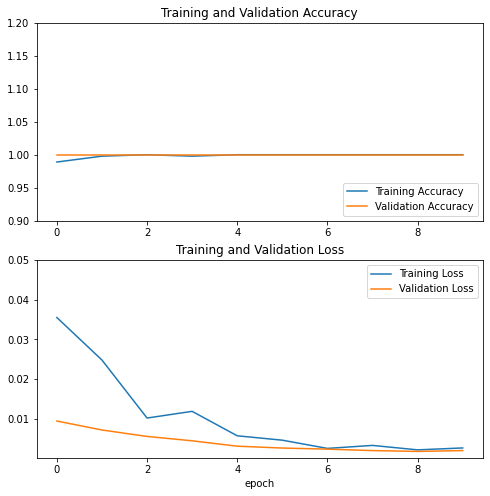

In [ ]:
# Model Histroy Training Data Results
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.9, 1.2])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0.0001, 0.05])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

* ***Testing the trained Tensorflow Model on testing set.***

In [ ]:
#Testing the Local Model Tensorflow Model
test_labels = test_batches.classes
print("Test Labels",test_labels)
print(test_batches.class_indices) 
predictions = model.predict(test_batches,steps=len(test_batches),verbose=0)
acc = 0
answer = []
for i in range(len(test_labels)):
    start = time.time()
    actual_class = test_labels[i]
    if predictions[i][actual_class] > 0.9 : 
        acc += 1
        answer.append(actual_class)
    else:
        answer.append(abs(1-actual_class))   
print("Accuarcy for DenseNet Tensorflow Model :",(acc/len(test_labels))*100,"%")

Test Labels [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
{'cat': 0, 'dog': 1}
Accuarcy for DenseNet Tensorflow Model : 100.0 %



* ***Now Converting TensorFlow Model to TensorFlow Lite Model*** 







In [ ]:
# Tensorflow Lite model convert
print("Convert Tensorflow Model to  TFLite Model Now")
start3 = time.time()
# Convert the model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TF Lite model.
with tf.io.gfile.GFile(path_to_tflite_model, 'wb') as f:
  f.write(tflite_model)
end3 = time.time() - start3
print("Time for converting to TFLite (in Seconds) -- DenseNets121 : " +str(end3))

#Create Label.txt for TFlite Interpreter
with open(Directory_Path+"/Models/Tensorflow-Lite-Models/labelmap.txt","w") as f :
  f.write("cat \ndog")

Convert Tensorflow Model to  TFLite Model Now
INFO:tensorflow:Assets written to: /tmp/tmp1kax2d79/assets
Time for converting to TFLite (in Seconds) -- DenseNets121 : 58.0638530254364


* ***Perfom Object Detection on TensorFlow Lite Model and get Final Results***

In [ ]:
#Object Detection for Tensorflow Lite Model (Divded into respective Code Blocks)

MODEL_NAME = Directory_Path+"/Models/Tensorflow-Lite-Models/"
GRAPH_NAME = "client.tflite"
LABELMAP_NAME = "labelmap.txt"
min_conf_threshold = 0.95
IM_DIR = Directory_Path+"/Images/model_test/"

# Get path to current working directory
CWD_PATH = os.getcwd()
PATH_TO_IMAGES = os.path.join(CWD_PATH,IM_DIR)
images = sorted(glob.glob(PATH_TO_IMAGES+'*.jpg'))

# Path to .tflite file, which contains the model that is used for object detection
PATH_TO_CKPT = os.path.join(CWD_PATH,MODEL_NAME,GRAPH_NAME)
print(str(PATH_TO_CKPT))

# Path to label map file
PATH_TO_LABELS = os.path.join(CWD_PATH,MODEL_NAME,LABELMAP_NAME)

# Load the label map
with open(PATH_TO_LABELS, 'r') as f:
    labels = [line.strip() for line in f.readlines()]

/content/Cat/Models/Tensorflow-Lite-Models/client.tflite


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


###Wrong Detection####


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



 Total TFLite Model Accuracy(in %) for 50 images :  49


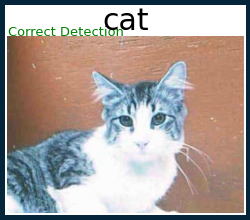

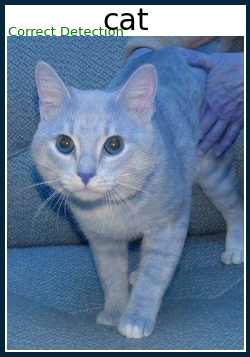

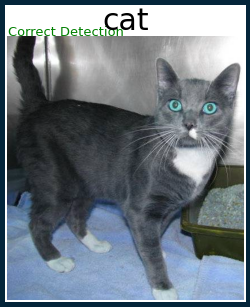

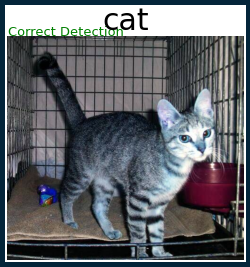

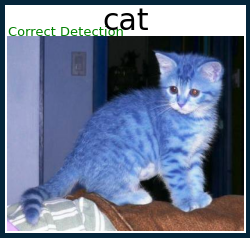

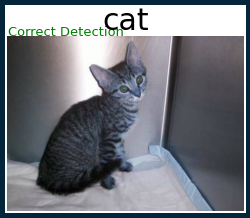

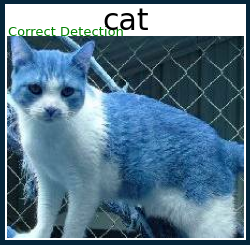

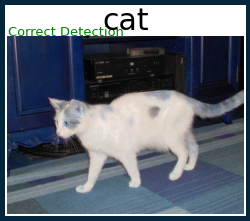

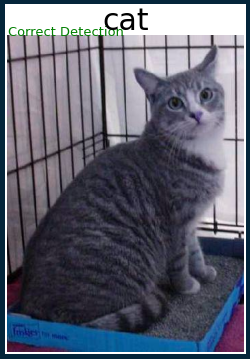

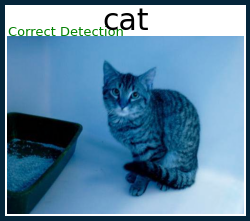

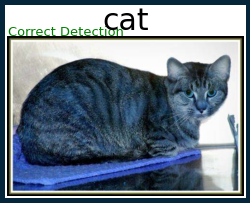

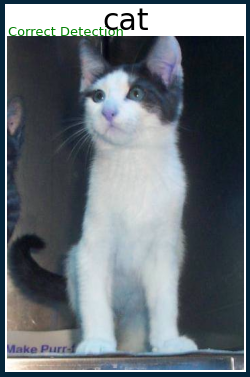

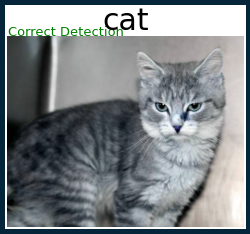

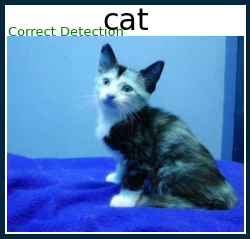

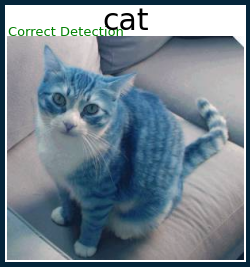

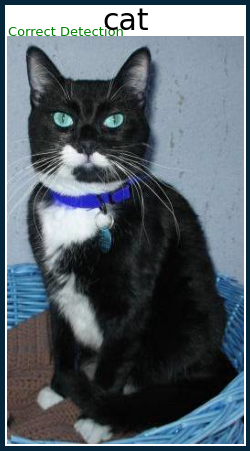

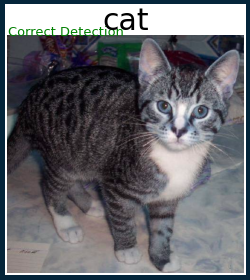

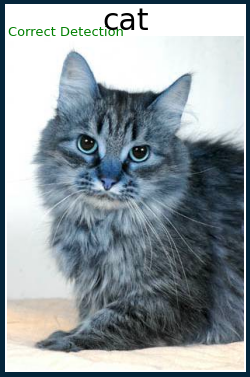

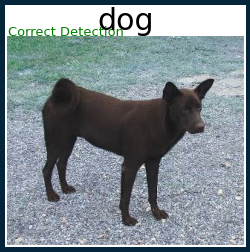

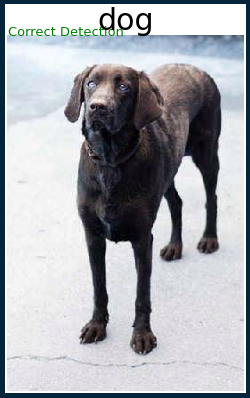

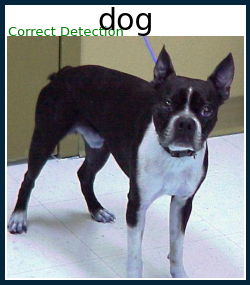

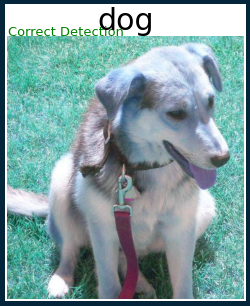

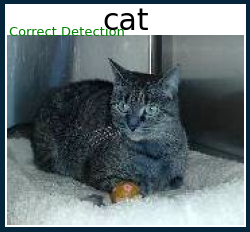

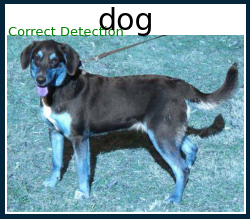

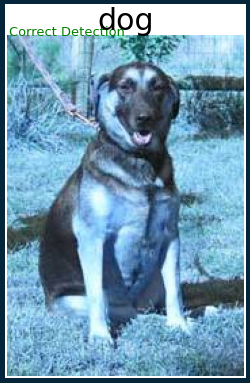

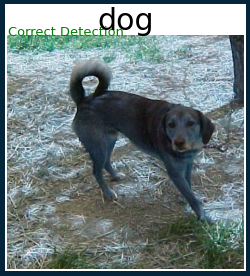

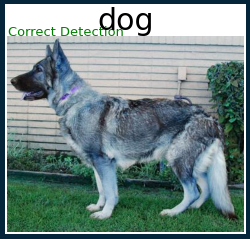

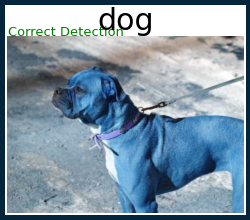

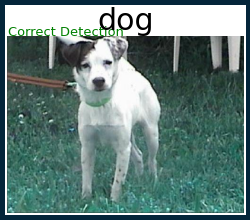

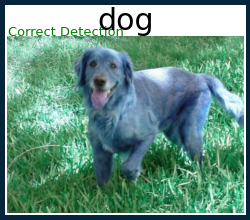

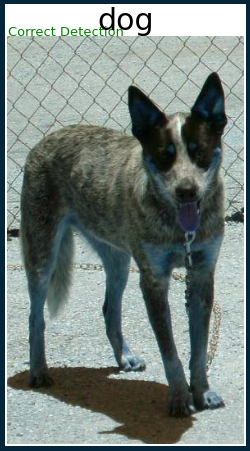

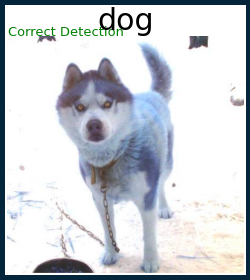

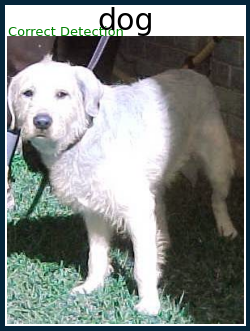

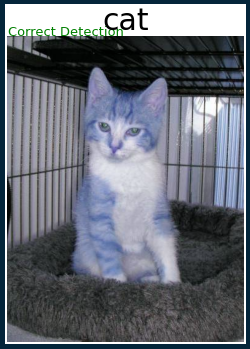

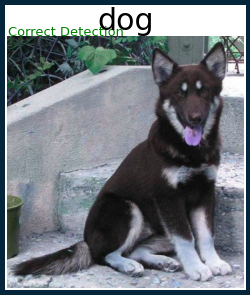

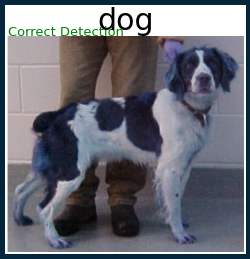

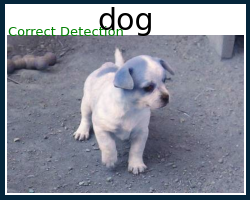

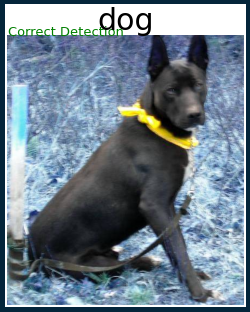

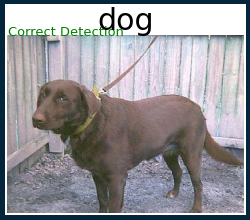

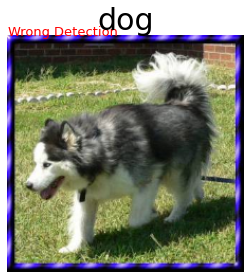

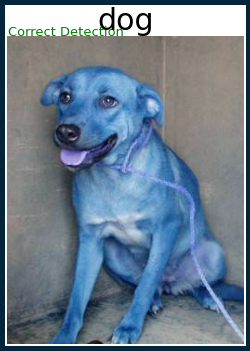

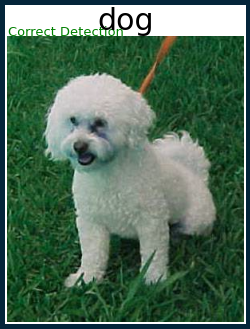

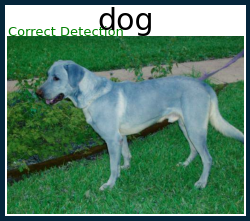

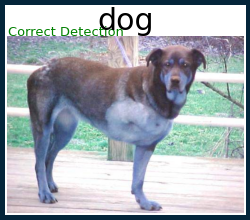

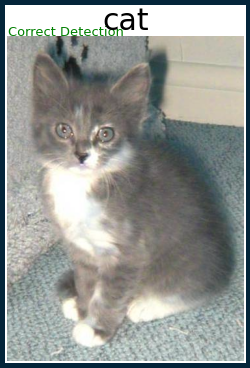

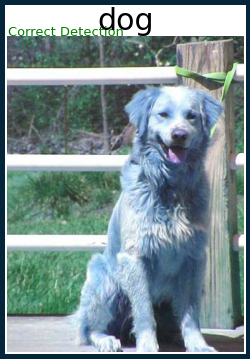

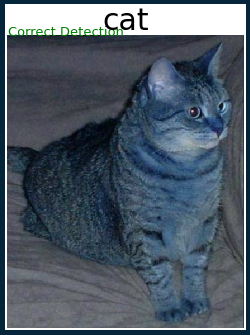

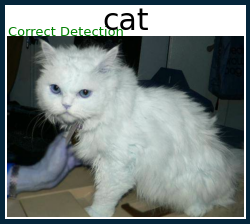

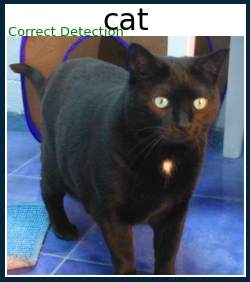

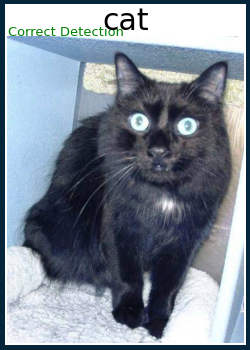

In [ ]:
#(Code Block 2) Function to test TFlite Model
def test_TfLite():
  
  interpreter = Interpreter(model_path=PATH_TO_CKPT)
  interpreter.allocate_tensors()

  # Get model details
  input_details = interpreter.get_input_details()
  height = input_details[0]['shape'][1]
  width = input_details[0]['shape'][2]
  floating_model = (input_details[0]['dtype'] == np.float32)
  input_mean = 127.5
  input_std = 127.5
  count = 0
  #Perform the testing on TFlite Model over the loop of images
  for image_path in images:
      # Load image and resize to expected shape [1xHxWx3]
      image = cv2.imread(image_path)
      image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      imH, imW, _ = image.shape 
      image_resized = cv2.resize(image_rgb, (width, height))
      input_data = np.expand_dims(image_resized, axis=0)

      # Normalize pixel values if using a floating model (i.e. if model is non-quantized)
      if floating_model:
          input_data = (np.float32(input_data) - input_mean) / input_std
      
      # Perform the actual detection by running the model with the image as input
      interpreter.set_tensor(input_details[0]['index'],input_data)
      interpreter.invoke()
      output = interpreter.tensor(interpreter.get_output_details()[0]["index"])
      predict_label = np.argmax(output()[0])
      if output()[0][predict_label] > min_conf_threshold:
          #print(labels[predict_label])
          count += 1
          plt.figure(figsize=(50,50), linewidth=10, edgecolor="#04253a")
          plt.subplot(5, 10, count)
          plt.imshow(image)  
          plt.title(labels[predict_label],fontsize=30)
          plt.text(0.5,-0.5,"Correct Detection",color='green',fontsize = 13) 
          #plt.figtext(-0.01, 0.01, "one text and next text", ha="center", fontsize=15)
          plt.axis("off")     
      else:  
          #If detection is wrong made it will indicate "wrong detection"
          plt.figure(figsize=(50,50))
          ax = plt.subplot(5, 10, count)
          plt.imshow(image_resized)
          plt.text(0.5,-0.5,"Wrong Detection",color='red',fontsize = 13) 
          plt.title(labels[predict_label],fontsize=30)
          plt.axis("off")       
      #TFLite Model Accuracy for 50 images (25-Dog and 25-Cat) 
  print("\n Total TFLite Model Accuracy(in %) for 50 images : ", count)   
test_TfLite()